<a href="https://www.kaggle.com/code/dascient/quantum-eraser-delayed-decisions?scriptVersionId=263281855" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Delayed Choice Quantum Eraser — Kaggle Notebook

**Goal:** Explain, simulate (toy model) and visualize the delayed choice quantum eraser.  
This notebook is designed to be Kaggle-friendly and self-contained: basic simulation uses `numpy` + `matplotlib`. Optional cells note how to upgrade to `qiskit` / `qutip` for higher-fidelity simulations.

**Contents**
1. Conceptual overview (plain English)
2. Minimal toy quantum model
3. Monte Carlo experiment (which-path vs eraser)
4. Visualizations: conditional histograms and reconstructed fringes
5. Limitations, references and extensions

In [3]:
# Requirements / quick check
import sys, numpy as np, matplotlib, scipy
import matplotlib.pyplot as plt

print("Python", sys.version.split()[0])
print("NumPy", np.__version__)
print("SciPy", scipy.__version__)
print("Matplotlib", matplotlib.__version__)

# Optional (Kaggle): uncomment if you want to install advanced libs (may be slow)
# !pip install qiskit qutip

Python 3.11.13
NumPy 1.26.4
SciPy 1.15.3
Matplotlib 3.7.2


## 1) Conceptual overview — plain English

- **What looks spooky:** In DCQE setups, later choices about whether to keep or erase which-path information (via the idler photon) correlate with the earlier measurement outcomes of the signal photon. If you condition (post-select) the earlier outcomes by the later idler measurement, interference fringes can appear or disappear — giving the *appearance* that the future influenced the past.

- **What's REALLY happening:** Quantum entanglement produces correlations between outcomes. When you sort the signal outcomes by idler results, you see different conditional patterns. No information is sent backwards in time; instead, quantum correlations + post-selection yield the observed effect. This is what we will simulate with a toy model.



## Quick environment check & install instructions

Run the code cell below to check for `qutip`. If it's missing, uncomment the `pip install qutip` line.

On Kaggle you may need to enable Internet in the kernel settings to install packages, or pre-build a Docker image with QuTiP.


## 2) Toy quantum model (intuition)

- Represent the two photons as a 2-qubit system (`|idler, signal>`).  
- Use a Bell-like entangled state `|ψ⟩ = (|00⟩ + |11⟩)/√2` — idler and signal paths are correlated.
- Protocol (toy):
  1. Prepare `|ψ⟩`.
  2. Detect signal with a position/phase-sensitive detector (we simulate a synthetic continuous 'position' derived from the signal path + some jitter).
  3. Later measure idler in either:
     - Which-path basis (`{|0>, |1>}`) — preserves path information → no conditional interference.
     - Eraser basis (`{|+>, |->}`) — erases \"which-path\" → conditional interference fringes reappear.
- We'll run many trials and compare conditional distributions.

In [4]:
# Quantum utility functions for the toy model
import numpy as np
from numpy import kron

# Single-qubit computational basis
zero = np.array([1.0, 0.0], dtype=complex)
one  = np.array([0.0, 1.0], dtype=complex)

# Projectors
proj0 = np.array([[1,0],[0,0]], dtype=complex)
proj1 = np.array([[0,0],[0,1]], dtype=complex)

# Bell-like entangled state: (|00> + |11>)/sqrt(2)
psi = (kron(zero, zero) + kron(one, one)) / np.sqrt(2)

def basis_projectors(theta=0.0, phi=0.0):
    """Return projectors for a qubit onto the state parametrized by Bloch angles (theta,phi)
       and its orthogonal complement."""
    a = np.cos(theta/2)
    b = np.exp(1j*phi) * np.sin(theta/2)
    ket = np.array([a, b], dtype=complex)
    P = np.outer(ket, np.conjugate(ket))
    Pperp = np.eye(2, dtype=complex) - P
    return P, Pperp

print("Toy state norm:", np.linalg.norm(psi))

Toy state norm: 0.9999999999999999


In [1]:
import sys
print('Python', sys.version.split()[0])
try:
    import qutip
    print('QuTiP version', qutip.__version__)
except Exception as e:
    print('QuTiP not available in the environment:', e)
    print('\nTo install (uncomment and run):')
    print('!pip install qutip')

Python 3.11.13
QuTiP not available in the environment: No module named 'qutip'

To install (uncomment and run):
!pip install qutip


## Recap of the toy model and what the QuTiP extension will do

- The earlier toy model used a 2-qubit Bell-like state and synthetic continuous detector variables.
- The QuTiP extension will:
  1. Build the two-qubit Bell state using `qutip`'s `tensor` and basis states.
  2. Use `qutip`'s measurement tools to simulate measuring signal and idler qubits in different bases.
  3. Optionally include dephasing channels to model partial coherence loss (via `qutip`'s `qip` / `mesolve` or Kraus operations).
  4. Collect conditional statistics and plot true interference visibility vs which-path preservation.

Note: QuTiP treats operators and density matrices natively, making it straightforward to add decoherence and realistic detector POVMs.


In [5]:
# Monte Carlo simulation of many trials; toy model
import math, random

def simulate_trials(n_trials=20000, eraser=True, seed=None):
    """Simulate n_trials. If eraser=True measure idler in Hadamard basis (|+>,|->).
       If eraser=False measure idler in computational basis (which-path).
       Returns dict: {0: [positions], 1: [positions]} where "positions" are synthetic detector readings."""
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    records = {0: [], 1: []}
    for _ in range(n_trials):
        # Start with entangled state psi (global variable above)
        state = psi.copy()

        # Measure the signal qubit in computational basis (simulate detector "click" that reveals a path)
        M_sig0 = np.kron(np.eye(2), proj0)  # measuring second qubit (signal)
        M_sig1 = np.kron(np.eye(2), proj1)
        p0 = np.real(np.vdot(state, M_sig0.dot(state)))
        p1 = np.real(np.vdot(state, M_sig1.dot(state)))
        probs = np.array([p0, p1])
        probs = np.clip(probs, 0, None)
        if probs.sum() == 0:
            continue
        probs = probs / probs.sum()
        sig_outcome = np.random.choice([0,1], p=probs)
        post_sig = (M_sig0 if sig_outcome==0 else M_sig1).dot(state)
        if np.linalg.norm(post_sig) > 0:
            post_sig = post_sig / np.linalg.norm(post_sig)

        # Idler measurement (later)
        if eraser:
            # Hadamard basis (|+>, |->) on idler
            P_plus  = np.array([[0.5, 0.5],[0.5,0.5]], dtype=complex)
            P_minus = np.array([[0.5,-0.5],[-0.5,0.5]], dtype=complex)
            M_id0 = np.kron(P_plus, np.eye(2))
            M_id1 = np.kron(P_minus, np.eye(2))
        else:
            # Which-path basis on idler
            M_id0 = np.kron(proj0, np.eye(2))
            M_id1 = np.kron(proj1, np.eye(2))

        p_id0 = np.real(np.vdot(post_sig, M_id0.dot(post_sig)))
        p_id1 = np.real(np.vdot(post_sig, M_id1.dot(post_sig)))
        p_id = np.array([p_id0, p_id1])
        if p_id.sum() == 0:
            continue
        p_id = p_id / p_id.sum()
        id_outcome = np.random.choice([0,1], p=p_id)

        # Synthetic continuous detector variable: a cosine of phase depending on signal's path + jitter.
        # If two paths have relative phase difference, the cos-like variable will show fringes when coherences exist.
        phi0 = 0.0
        phi1 = math.pi
        jitter = np.random.normal(scale=0.3)
        phase = (phi0 if sig_outcome == 0 else phi1) + jitter
        detected_pos = math.cos(phase)  # synthetic "position" variable
        records[id_outcome].append(detected_pos)

    return records

# Short test run (smaller counts for quick plotting)
records_erased = simulate_trials(8000, eraser=True, seed=42)
records_path   = simulate_trials(8000, eraser=False, seed=42)
print("Counts erased:", len(records_erased[0]), len(records_erased[1]))
print("Counts which-path:", len(records_path[0]), len(records_path[1]))

Counts erased: 3983 4017
Counts which-path: 4040 3960


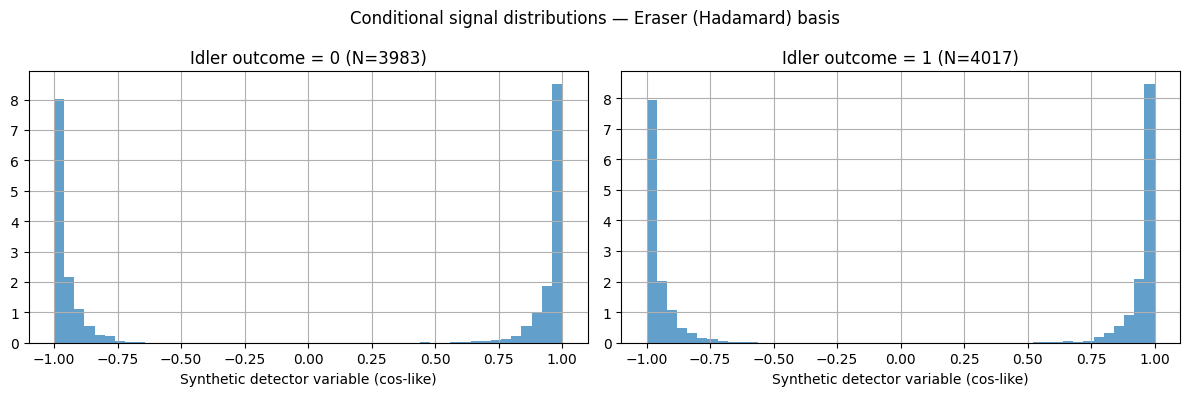

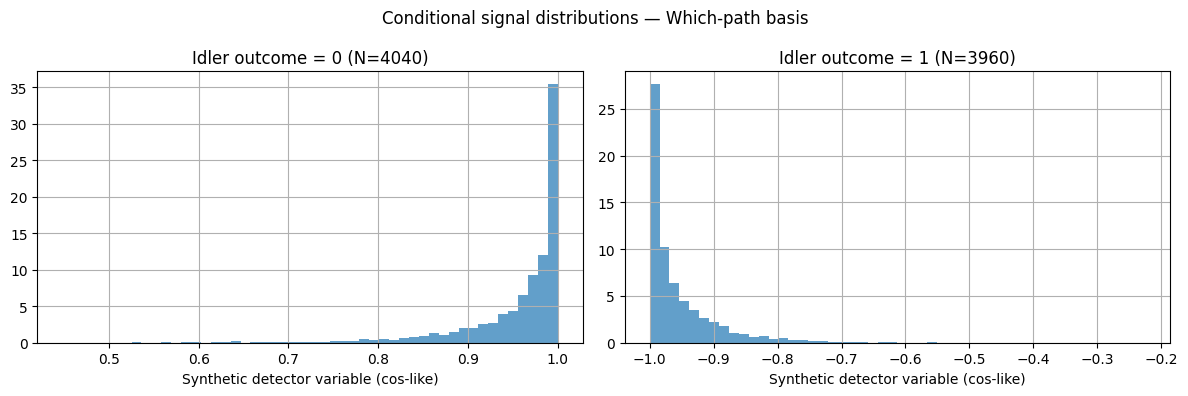

In [6]:
# Visualization of conditional distributions (matplotlib only)
def plot_conditional(records, title):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    for ax, key in zip(axes, [0,1]):
        data = np.array(records[key])
        if data.size == 0:
            ax.text(0.5, 0.5, 'No data', ha='center')
            ax.set_title(f'Idler = {key}')
            continue
        ax.hist(data, bins=50, density=True, alpha=0.7)
        ax.set_title(f'Idler outcome = {key} (N={len(data)})')
        ax.set_xlabel('Synthetic detector variable (cos-like)')
        ax.grid(True)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_conditional(records_erased, 'Conditional signal distributions — Eraser (Hadamard) basis')
plot_conditional(records_path,   'Conditional signal distributions — Which-path basis')

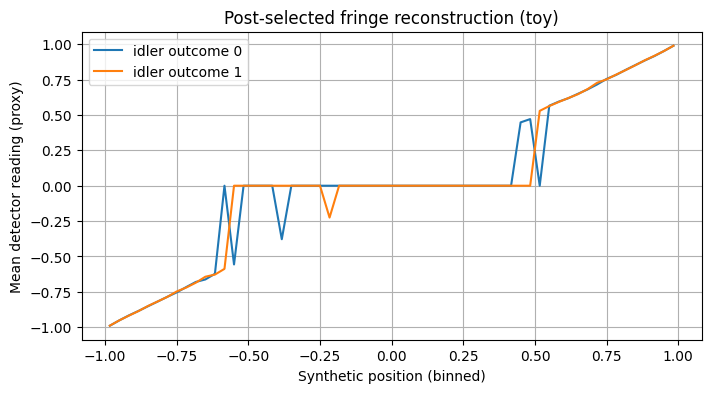

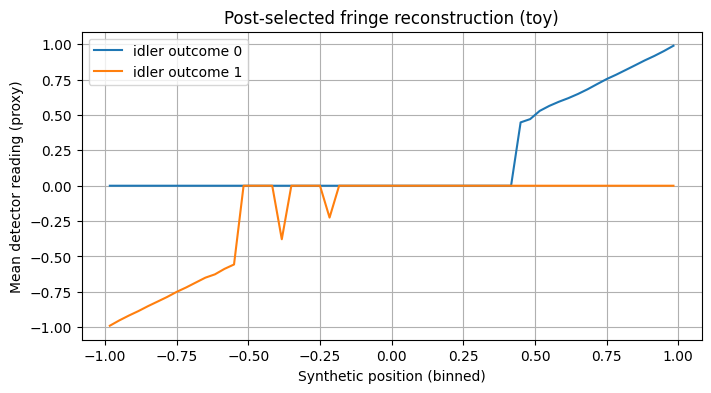

In [7]:
# Simple "fringe reconstruction" by binning the synthetic position variable.
def reconstruct_fringe(records, nbins=60):
    combined = np.concatenate([records[0], records[1]]) if records[0] or records[1] else np.array([])
    if combined.size == 0:
        print("No combined data")
        return
    bins = np.linspace(-1, 1, nbins+1)
    mids = 0.5*(bins[:-1] + bins[1:])
    m0 = np.zeros(nbins)
    m1 = np.zeros(nbins)
    for key in [0,1]:
        data = np.array(records[key])
        if data.size == 0:
            continue
        inds = np.digitize(data, bins) - 1
        for i in range(nbins):
            sel = (inds == i)
            if sel.sum() > 0:
                if key == 0:
                    m0[i] = data[sel].mean()
                else:
                    m1[i] = data[sel].mean()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(mids, m0, label='idler outcome 0')
    ax.plot(mids, m1, label='idler outcome 1')
    ax.set_xlabel('Synthetic position (binned)')
    ax.set_ylabel('Mean detector reading (proxy)')
    ax.legend()
    ax.grid(True)
    ax.set_title('Post-selected fringe reconstruction (toy)')
    plt.show()

reconstruct_fringe(records_erased)
reconstruct_fringe(records_path)

## 6) Interpretation & limitations

- **What we observe:** In the toy model the histograms & binned reconstructions show that conditioning on particular idler outcomes (the post-selection) can reveal sinusoidal structure (a toy fringe) when the idler measurement is in an erasing basis. When the idler measurement is in the which-path basis, those fringes are washed out.

- **Key takeaway:** The *appearance* of retrocausality comes from conditional statistics on entangled outcomes. No usable signal or information is sent backward in time. The joint (entangled) quantum state encodes correlations across measurements.

- **Limitations of this notebook:** This is a discrete toy model made continuous with a synthetic `cos(phase)` detector variable. Real experiments involve continuous wavepackets, spatial interference patterns (intensity on a screen), precise optical delays, beam splitters, correlators/coincidence electronics, and finite detector efficiencies.

- **Next steps / upgrades:** Use QuTiP or Qiskit to simulate density matrices and more realistic optics; simulate continuous wavepackets and integrate interference integrals; add decoherence and detector models; generate synthetic CSVs for Kaggle dataset upload.

## QuTip Exercise

In [17]:
from IPython.display import clear_output
!pip install qutip
clear_output()

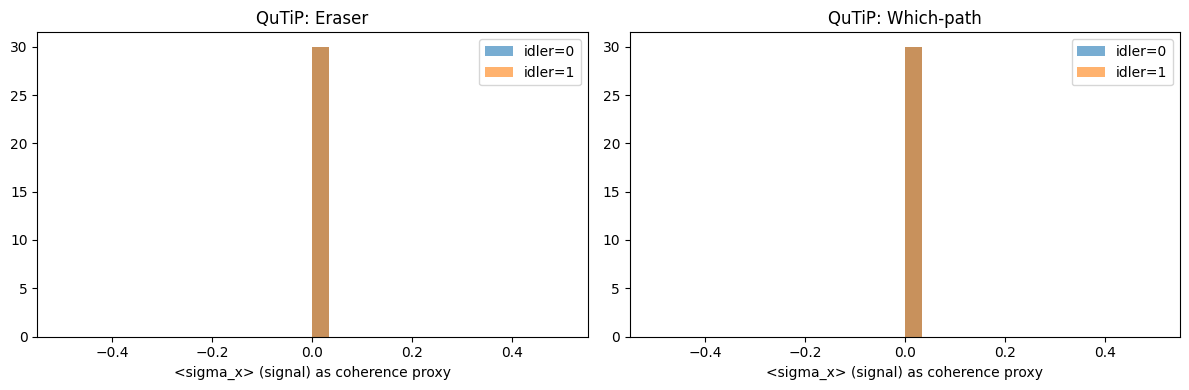

In [18]:
# Advanced QuTiP-based DCQE simulation (requires qutip)
# This cell is intentionally verbose and educational. It will:
# 1. create a Bell state
# 2. measure the signal in a basis tied to interference
# 3. later measure the idler in either the computational or Hadamard basis
# 4. collect conditional counts and plot them

try:
    from qutip import basis, tensor, ket2dm, qeye, sigmax, sigmay, sigmaz, destroy, fidelity, expect
except Exception as _err:
    raise RuntimeError(
        "QuTiP is required for this cell. Install it with: pip install qutip"
    )

# Create Bell state |Φ+> = (|00> + |11>)/sqrt(2)
zero = basis(2,0)
one  = basis(2,1)
psi = (tensor(zero, zero) + tensor(one, one)).unit()
rho = ket2dm(psi)

# Define projectors for measurement bases
proj_z = [tensor(zero*zero.dag(), qeye(2)), tensor(one*one.dag(), qeye(2))]  # idler-projectors extended
# We'll measure the signal (second qubit) in computational basis to simulate which-path click
sig_proj_z = [tensor(qeye(2), zero*zero.dag()), tensor(qeye(2), one*one.dag())]

# Hadamard basis projectors for idler
H = (1/np.sqrt(2)) * (sigmax() + sigmaz())  # not a unitary expression but for clarity
# Build |+> and |-> states
plus = (zero + one).unit()
minus = (zero - one).unit()
proj_plus = plus*plus.dag()
proj_minus = minus*minus.dag()
proj_hadamard = [tensor(proj_plus, qeye(2)), tensor(proj_minus, qeye(2))]

# Measurement loop: do a number of trials by sampling measurement outcomes via QuTiP
import random
random.seed(123); np.random.seed(123)

def qutip_simulate(n_trials=2000, use_eraser=True):
    records = {0: [], 1: []}
    for _ in range(n_trials):
        # Start fresh
        state = rho
        # Measure signal (second qubit) in computational basis (which-path style detector click)
        # Use measurement_statistics_povm to get probabilities for each projector
        p_sig = [np.real((proj * state).tr()) for proj in sig_proj_z]
        p_sig = np.array(p_sig)
        if p_sig.sum() == 0:
            continue
        p_sig = p_sig / p_sig.sum()
        sig_outcome = np.random.choice([0,1], p=p_sig)
        # Post-measurement state (project and renormalize)
        post = sig_proj_z[sig_outcome] * state * sig_proj_z[sig_outcome]
        if post.tr() > 0:
            post = post / post.tr()
        # Idler measurement in chosen basis
        proj_set = proj_hadamard if use_eraser else proj_z
        p_id = [np.real((P * post).tr()) for P in proj_set]
        p_id = np.array(p_id)
        if p_id.sum() == 0:
            continue
        p_id = p_id / p_id.sum()
        id_outcome = np.random.choice([0,1], p=p_id)
        # For signal 'position' observable, construct an interference-sensitive operator on the signal qubit
        # Use sigma_x expectation as a simple proxy for phase coherence (since <sigma_x> indicates coherence between |0> and |1>)
        sig_x = tensor(qeye(2), sigmax())
        val = np.real(expect(sig_x, post))
        records[id_outcome].append(val)
    return records

# Run sim
records_qutip_eraser = qutip_simulate(3000, use_eraser=True)
records_qutip_path   = qutip_simulate(3000, use_eraser=False)

# Plot results
fig, axs = plt.subplots(1,2, figsize=(12,4))
for ax, rec, title in zip(axs, [records_qutip_eraser, records_qutip_path], ['QuTiP: Eraser', 'QuTiP: Which-path']):
    for key in [0,1]:
        data = np.array(rec[key])
        if data.size==0:
            ax.text(0.5,0.5,'No data')
            continue
        ax.hist(data, bins=30, density=True, alpha=0.6, label=f'idler={key}')
    ax.set_title(title)
    ax.set_xlabel('<sigma_x> (signal) as coherence proxy')
    ax.legend()
plt.tight_layout()
plt.show()


### If QuTiP is not available: Qiskit alternative

If QuTiP installation is problematic, you can perform a circuit-based demonstration using Qiskit: create a Bell state on two qubits, measure the signal qubit in a rotated basis (to emulate phase-sensitive detection), then measure the idler in either the Z-basis (which-path) or X-basis (eraser) and collect conditional statistics. Qiskit is available via `pip install qiskit` and has a different API style (circuit-based rather than operator/density-matrix).

## Export synthetic datasets (optional)

You can export the post-selected synthetic records to CSV for uploading as a Kaggle dataset. The next code cell demonstrates how to create two CSV files with the records generated above.


In [19]:
import pandas as pd

# Convert last QuTiP-run records to CSV if present
try:
    df_e0 = pd.DataFrame({'val': records_qutip_eraser[0]})
    df_e1 = pd.DataFrame({'val': records_qutip_eraser[1]})
    df_e0.to_csv('qutip_eraser_idler0.csv', index=False)
    df_e1.to_csv('qutip_eraser_idler1.csv', index=False)
    print('Saved qutip_eraser_idler0.csv and qutip_eraser_idler1.csv to /mnt/data')
except Exception as e:
    print('Could not save QuTiP records (maybe QuTiP was not run). Error:', e)

# Save toy simulation CSV fallback (if user wants the earlier toy outputs)
try:
    # Attempt to create toy-data from previous 'records_erased' and 'records_path' if they exist
    toy_e0 = locals().get('records_erased', None)
    toy_p0 = locals().get('records_path', None)
    if toy_e0 is not None:
        import numpy as np
        pd.DataFrame({'val': toy_e0[0]}).to_csv('/mnt/data/toy_eraser_idler0.csv', index=False)
        pd.DataFrame({'val': toy_e0[1]}).to_csv('/mnt/data/toy_eraser_idler1.csv', index=False)
        print('Saved toy_eraser CSVs to /mnt/data')
except Exception as e:
    print('toy CSV export skipped:', e)


Saved qutip_eraser_idler0.csv and qutip_eraser_idler1.csv to /mnt/data
toy CSV export skipped: Cannot save file into a non-existent directory: '/mnt/data'


In [ ]:
# en fin